# Regression Inference

In this Jupyter Lab, I'll be analyzing the relationship between draft position and success in the NFL (National Football League). The NFL draft is an annual event in which every NFL team takes turns choosing players that they will add to their team. There are around 200 selections, called "picks" made every year, although this number has changed over the years.

The `nfl` table has five columns, the name of the `Player`, the `Salary` that player made for the 2019 season, the year that player was drafted (`Year Drafted`), the number of the draft pick that was used when the player was drafted (`Pick Number`), and the `Position` in football that player plays.

Each row in `nfl` corresponds to one player who played in the 2019 season.

In [5]:
import numpy as np
import pandas as pd

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)
from matplotlib import patches
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [6]:
def standard_units(array):
    """Transforms data into standard units. 
    Input: a numpy array of data
    Output: an array of the standard units"""
    return (array- np.mean(array)) / np.std(array)

def correlation(df, data1, data2):
    """Finds the correlation between two data columns data1 and data2 
    in a pandas Dataframe, df."""
    r = np.mean(standard_units(df[data1]) * standard_units(df[data2]))
    return r

def parameters(df, colx, coly):
    """Calculates the y-intercept and the slope of the regression 
    line between two data columns in a pandas Dataframe, df.
    Input: dataframe, colx, coly
    Output: numpy array (index 0: slope, index 1: y - intercept)"""
    x = df[colx]
    y = df[coly]
    
    r = correlation(df, colx, coly)
    
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    x_sd = np.std(x)
    y_sd = np.std(y)
    
    slope = (y_sd / x_sd) * r
    intercept = y_mean - (slope * x_mean)
    return np.array([slope, intercept])

Run the next cell to load the dataset

In [7]:
nfl = pd.read_csv("nfl.csv")
nfl

,Player,Salary,Year Drafted,Pick Number,Position
0,Baker Mayfield,570000,2018,1,QB
1,Cam Newton,16200000,2011,1,QB
2,Eli Manning,11500000,2004,1,QB
3,Eric Fisher,10350000,2013,1,OT
4,Jadeveon Clowney,15967200,2014,1,DE
...,...,...,...,...,...
1157,Tom Brady,14000000,2000,199,QB
1158,Emeke Egbule,495000,2019,200,LB
1159,Foyesade Oluokun,570000,2018,200,S
1160,Laurent Duvernay-Tardif,6203000,2014,200,OT


I added a column to the dataframe called `Career Length` that corresponds to how long a player has been in the NFL to the `nfl` dataframe. I assumed that the `Career Length` is from when they were drafted to year 2020. Therefore, if a player was drafted in 2015, their career length is 5:
$$2020-2015=5$$

In [8]:
nfl["Career Length"] = 2020 - nfl["Year Drafted"]

nfl.head(5)

,Player,Salary,Year Drafted,Pick Number,Position,Career Length
0,Baker Mayfield,570000,2018,1,QB,2
1,Cam Newton,16200000,2011,1,QB,9
2,Eli Manning,11500000,2004,1,QB,16
3,Eric Fisher,10350000,2013,1,OT,7
4,Jadeveon Clowney,15967200,2014,1,DE,6


I investigated the data visually before analyzing it numerically. The first relationship I analyzed is the relationship between a player's `Pick Number` and their `Career Length`. I created a scatter plot with the line of best fit.

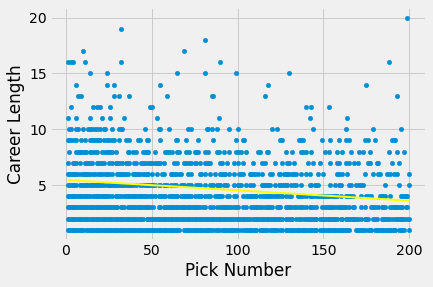

In [9]:
para = parameters(nfl, "Pick Number", "Career Length")
slope = para.item(0)
intercept = para.item(1)
yfit = slope * nfl["Pick Number"] + intercept
nfl.plot.scatter("Pick Number", "Career Length")
plt.plot(nfl['Pick Number'], yfit, lw=2, color='yellow')

I used the `correlation` function to assign the correlation between `Pick Number` and `Career Length` to `pick_length_correlation`. 


In [10]:
pick_length_correlation = correlation(nfl, 'Pick Number', 'Career Length')
pick_length_correlation

-0.1651733273764684

It is observed that the correlation between `Pick Number` and `Career Length` is negative!

To test whether the slope of the true line of best fit for `Pick Number` and `Career Length` is not zero, hence there is some correlation/association between `Pick Number` and `Career Length`, I run a hypothesis test! 

Null Hypothesis: There is no correlation between `Pick Number` and `Career Length`.

Alternative Hypothesis: The is a correlation between `Pick Number` and `Career Length`.

The relationship between the slope and correlation is that if the slope is increasing/decreasing then the correlation will be positive or negative respectively. However, if the slope is x=0, then there is no correlation between the variables.

I wrote a function `one_resample_r` that performs a bootstrap and returns the correlation between `Pick Number` and `Career Length` in the resample. `one_resample_r` takes three arguments, a dataframe `df` and the labels of the columns you are finding the correlation between, `data1` and `data2`.

In [15]:
def one_resample_r(df, data1, data2):
    """Performs one resample (bootrstap method) and returns 
    the correlation between two variables
    
    Input: df -> pandas dataframe, data1: dataframe column/ variable, 
    data2: dataframe column/ variable
    
    Output: correlation between data1 and data2, which is an integer"""
    one_sample = df.sample(len(df), replace = True)
    sample_r = correlation(one_sample, data1, data2)
    return sample_r

In [16]:
one_resample = one_resample_r(nfl, "Pick Number", "Career Length")
one_resample

-0.19406389977263536

I then generated 1000 bootstrapped correlations for `Pick Number` and `Career Length`, stored my results in a numpy array called `resampled_correlations_pc`, and ploted a histogram of those results.

array([[<AxesSubplot:title={'center':'Resampled Correlations, Pick Number vs Career Length'}>]],
      dtype=object)

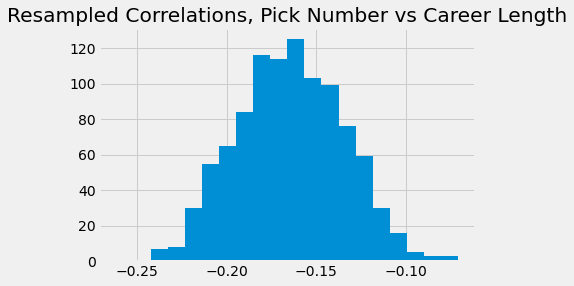

In [17]:
resampled_correlations_pc = np.array([])

for i in np.arange(1000):
    sample = one_resample_r(nfl, "Pick Number", "Career Length")
    resampled_correlations_pc = np.append(resampled_correlations_pc, sample)

pd.DataFrame({"Resampled Correlations, Pick Number vs Career Length": resampled_correlations_pc}).hist(bins=20)

After that I calculated the 95% confidence interval for the resampled correlations and assigned it to either `True` or `False` to `reject` variable, depending on whether I can reject the null hypothesis or accept the null hypothesis using a 5% p-value cutoff.

In [18]:
lower_bound_pc = np.percentile(resampled_correlations_pc, 2.5)
upper_bound_pc = np.percentile(resampled_correlations_pc, 97.5)

reject = not((lower_bound_pc<=0) and (upper_bound_pc>=0))


print(f"95% CI: [{lower_bound_pc}, {upper_bound_pc}] , Reject the null: {reject}")

95% CI: [-0.21927915093832478, -0.10776337157764512] , Reject the null: True


Now, I will be investigating the relationship between `Pick Number` and `Salary`. I first inspected the data visually and plotted a line of best fit.

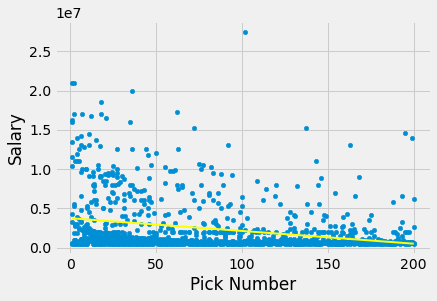

In [19]:
para = parameters(nfl, "Pick Number", "Salary")
slope = para.item(0)
intercept = para.item(1)
yfit = slope * nfl["Pick Number"] + intercept
nfl.plot.scatter("Pick Number", "Salary")
plt.plot(nfl['Pick Number'], yfit, lw=2, color='yellow')

Using the function `correlation`, I found the correlation between `Pick Number` and `Salary` and assigned it to `pick_salary_correlation` variable.

In [20]:
pick_salary_correlation = correlation(nfl, 'Pick Number', 'Salary')
pick_salary_correlation

-0.2812388644684753

There is a negative association between `Pick Number` and `Salary`! 

To test whether the slope of the true line of best fit for `Pick Number` and `Salary` is not zero, hence there is some correlation between `Pick Number` and `Salary`, I went through and run a hypothesis test! 

Null Hypothesis: There is no correlation between `Pick Number` and `Salary`.

Alternative Hypothesis: The is a correlation between `Pick Number` and `Salary`.

I continued with running 1000 bootstrapped correlations for `Pick Number` and `Salary` and appended them to the array `resampled_correlations_salary`. Lastly, I plotted a histogram of those results.

array([[<AxesSubplot:title={'center':'Resampled Correlations for Salary'}>]],
      dtype=object)

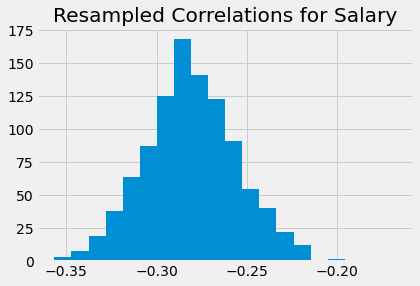

In [21]:
resampled_correlations_salary = np.array([])

for i in np.arange(1000):
    sample = one_resample_r(nfl, "Pick Number", "Salary")
    resampled_correlations_salary = np.append(resampled_correlations_salary, sample)

pd.DataFrame({"Resampled Correlations for Salary": resampled_correlations_salary}).hist(bins=20)

I calculated the 95% confidence interval for the resampled correlations and assigned the `reject_sal` variable to a boolean, depending on whether I found I could reject or accept the null hypothesis based on the 5% p-value cutoff.

In [22]:
lower_bound_sal = np.percentile(resampled_correlations_salary, 2.5)
upper_bound_sal = np.percentile(resampled_correlations_salary, 97.5)
reject_sal = not((lower_bound_sal<=0)and (upper_bound_sal>=0))

print(f"95% CI: [{lower_bound_sal}, {upper_bound_sal}], Reject the null: {reject_sal}")

95% CI: [-0.3296455420391032, -0.23021439782504277], Reject the null: True


To evaluate how effective my predictions for career length and salary based on pick number were I calculated the residuals of the line of best fit.

First I calculated the slope and intercept for the line of best fit for `Pick Number` vs `Career Length` and for `Pick Number` vs `Salary`. I, then, assigned these values to `career_length_slope`, `career_length_intercept`, `salary_slope`, and `salary_intercept` respectively. I used the function `parameters` which returns a two-item array containing the slope and intercept of a linear regression line.

In [23]:
career_length_slope = parameters(nfl, 'Pick Number', 'Career Length')[0]
print(career_length_slope)
career_length_intercept = parameters(nfl, 'Pick Number', 'Career Length')[1]
print(career_length_intercept)

salary_slope = parameters(nfl, 'Pick Number', 'Salary')[0]
print(salary_slope)
salary_intercept = parameters(nfl, 'Pick Number', 'Salary')[1]
print(salary_intercept)

-0.009271872759513229
5.453855957849608
-16229.882114775128
3732861.9860013146


I drew a scatter plot of the residuals for each line of best fit for `Pick Number` vs `Career Length` and for `Pick Number` vs `Salary`.

<AxesSubplot:xlabel='Pick Number', ylabel='Salary Residuals'>

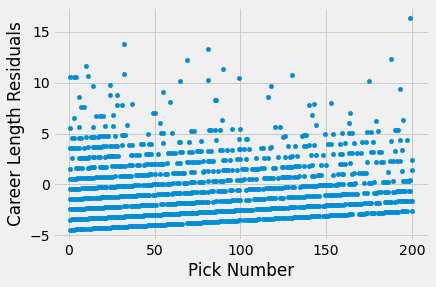

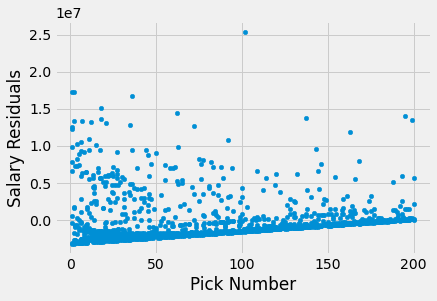

In [24]:
predicted_career_lengths = career_length_intercept + career_length_slope * nfl['Pick Number']
predicted_salaries = salary_intercept + salary_slope * nfl['Pick Number']


career_length_residuals = nfl['Career Length'] - predicted_career_lengths
salary_residuals = nfl['Salary'] - predicted_salaries

nfl_with_residuals = nfl.copy()
nfl_with_residuals["Career Length Residuals"] = career_length_residuals
nfl_with_residuals["Salary Residuals"] = salary_residuals

nfl_with_residuals.plot.scatter("Pick Number", "Career Length Residuals")
nfl_with_residuals.plot.scatter("Pick Number", "Salary Residuals")

Based on these plots of residuals, I came to the conclusion that linear regression is not a good model for `Pick Number` vs `Career Length` and for `Pick Number` vs `Salary`. Because, of the recression lines observed in both graphs. The residuals should always been randomized for linear regression to be the model of choice for data prediction.

It looks like the largest residuals are positive residuals, which is something I investigated more closely.

For this investigation I used the `nfl_with_residuals` table, assigned `greatest_career_length_residual` to the string of the player's name with the largest positive residual for `Pick Number` vs `Career Length`.

In [25]:
greatest_career_length_residual = nfl_with_residuals.sort_values(by = 'Career Length Residuals', ascending = False)
greatest_career_length_residual = greatest_career_length_residual.iloc[0]
greatest_career_length_residual = greatest_career_length_residual['Player']
greatest_career_length_residual


'Tom Brady'

Then I investigated the residuals for salary.

In [26]:
nfl_with_residuals.sort_values(by = ["Salary Residuals"], ascending=False).iloc[:10,:].drop(columns = ['Year Drafted', 'Career Length Residuals'])

,Player,Salary,Pick Number,Position,Career Length,Salary Residuals
711,Kirk Cousins,27500000,102,QB,8,2.542259e+07
12,Marcus Mariota,20922000,2,QB,5,1.722160e+07
5,Jameis Winston,20922000,1,QB,5,1.720537e+07
304,Derek Carr,19900000,36,QB,6,1.675141e+07
157,Joe Flacco,18500000,18,QB,12,1.505928e+07
477,Jimmy Garoppolo,17200000,62,QB,6,1.447339e+07
1139,Antonio Brown,14625000,195,WR,10,1.405697e+07
887,Grady Jarrett,15209000,137,DT,5,1.369963e+07
160,Melvin Ingram,17000000,18,DE,8,1.355928e+07
1157,Tom Brady,14000000,199,QB,20,1.349688e+07


From the data above, I noticed that the highest payed players are mostly Quarter Backs, which might be the reason our residuals are large, affecting our analysis.

## Prediction Intervals

If I wanted to predict my career length based on a specific pick number, which is 169. Instead of using the best fit line generated from the sample, I wanted to generate an interval for this predicted career length.

I defined a function `one_resample_prediction` that generates a bootstrapped sample from the `df` argument, calculates the line of best fit for `ycol` vs `xcol` for that resample, and predicts a value based on `xvalue`.

In [29]:
def one_resample_prediction(df, colx, coly, xvalue):
    """Generates a bootstrapped sample from the df argument, 
    calculates the line of best fit for ycol vs xcol for that resample, 
    and predicts a value based on xvalue.
    
    Inputs: df-> pandas dataframe, colx -> pandas column/variable, 
    coly-> pandas column/variable, xvalue -> pick number
    
    Outputs: predicted number -> integer"""
    
    one_sample = df.sample(len(df), replace = True)
    slope = parameters(one_sample, colx, coly)[0]
    intercept = parameters(one_sample, colx, coly)[1]
    predicted = intercept + slope * xvalue
    return predicted

In [30]:
evans_career_length_pred = one_resample_prediction(nfl, "Pick Number", "Career Length", 169)
evans_career_length_pred

4.068967696403545

I assigned `resampled_predictions` to be an array that will contain 1000 resampled predictions for a career length based on the pick number I chose above (169), and then generated a histogram of it.

array([[<AxesSubplot:title={'center':'Resampled Career Length Predictions'}>]],
      dtype=object)

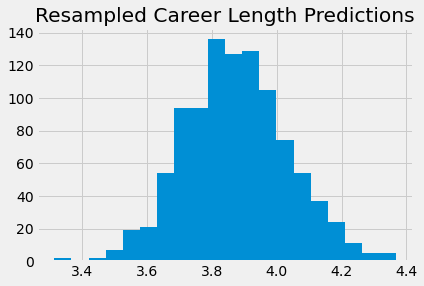

In [31]:
resampled_predictions = np.array([])

for i in np.arange(1000):
    sample = one_resample_prediction(nfl, "Pick Number", "Career Length", 169)
    resampled_predictions = np.append(resampled_predictions, sample)

pd.DataFrame({"Resampled Career Length Predictions": resampled_predictions}).hist(bins=20)

Using `resampled_predictions` from above, I generated a 99% confidence interval for the chosed predicted career length of pick number 169.

In [32]:
lower_bound_evan = np.percentile(resampled_predictions, 2.5)
upper_bound_evan = np.percentile(resampled_predictions, 97.5)

print(f"99% CI: [{lower_bound_evan}, {upper_bound_evan}]")

99% CI: [3.5603609148675965, 4.188055788569574]


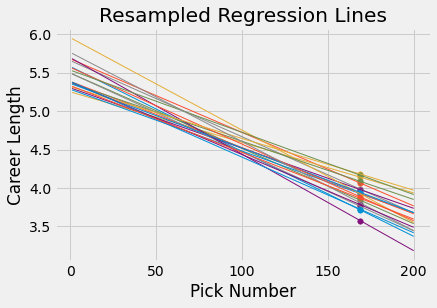

In [39]:
lines = pd.DataFrame(columns=['slope','intercept'])
x=169

for i in np.arange(20):
    resamp = nfl.sample(len(nfl), replace=True)
    resample_pars = parameters(resamp, "Pick Number", "Career Length") 
    slope = resample_pars.item(0)
    intercept = resample_pars.item(1)
    lines = lines.append({'slope':slope, 'intercept':intercept}, ignore_index=True)

lines['prediction at x='+str(x)] = lines['slope']*x + lines['intercept']
xlims = [min(nfl["Pick Number"]), max(nfl["Pick Number"])]
left = xlims[0]*lines['slope'] + lines['intercept']
right = xlims[1]*lines['slope'] + lines['intercept']
fit_x = x*lines['slope'] + lines['intercept']
for i in range(20):
    plt.plot(xlims, np.array([left[i], right[i]]), lw=1)
    plt.scatter(x, fit_x[i], s=30)
plt.ylabel("Career Length");
plt.xlabel("Pick Number");
plt.title("Resampled Regression Lines");